In [4]:
import anndata as ad 
import os
import pandas as pd 
import scglue 
import scanpy as sc 
#generate rna
path='2024-02-25-19_54_56'

#generate rna 
# rna = ad.read_h5ad('/home/ubuntu0/scBasset/Chen-2019-RNA.h5ad')
# rna.layers["counts"] = rna.X.copy()

# #select high expressive genes as in the tutorial the number 2000
# sc.pp.highly_variable_genes(rna, n_top_genes=60000, flavor="seurat_v3")

# sc.pp.normalize_total(rna)
# sc.pp.log1p(rna)
# sc.pp.scale(rna)
# sc.tl.pca(rna, n_comps=100, svd_solver="auto")

# sc.pp.neighbors(rna, metric="cosine")
# sc.tl.umap(rna)
# sc.pl.umap(rna,color='cell_type')

# scglue.data.get_gene_annotation(
#     rna, gtf="/home/ubuntu0/GLUE/evaluation/workflow/scripts/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
#     gtf_by="gene_name"
# )
# rna=ad.read_h5ad('unfiltered_rna.h5ad')
atacl=[]
for i in range(8):
    atacl.append(ad.read_h5ad(path+'data/embedatac%s.h5ad'%str(i)))


In [8]:
#get atac0,atac1,atac2

guidancel=[]
for i in range(8):
    atac=atacl[i]
    scglue.data.lsi(atac, n_components=100, n_iter=15)#enable lsi embedding
    split = atac.var_names.str.split(r"[:-]")
    atac.var["chrom"] = atac.var['chr']
    atac.var["chromStart"] = atac.var['start']
    atac.var["chromEnd"] = atac.var['end']
    guidance=scglue.genomics.rna_anchored_guidance_graph(rna, atac)
    atac.obsm['proj']=pd.read_csv(path+'scb_embedding/scb'+str(i)+'.csv',index_col=0).values #add scbasset embedding
    guidancel.append(guidance)
    atac.write_h5ad(path+'data/embedatac'+str(i)+'.h5ad')#contain lsi and scb
    
sc.pp.subsample(rna,n_obs=4000,random_state=42) #filter rna here 

/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|███████████████████████████████████████████████████████████████████████████████████████| 28930/28930 [00:00<00:00, 56968.16it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|███████████████████████████████████████████████████████████████████████████████████████| 28930/28930 [00:00<00:00, 56140.26it/s]
/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scglue/num.py:289: RuntimeWarning: divide by zero encountered in divide
  idf = X.shape[0] / X.sum(axis=0)
window_graph: 100%|███████████████████████████████████████████████████████████████████████████████████████| 28930/28930 [00:00<00:00, 56162.63it/s]
/home/ubuntu0/miniconda3/env

In [9]:
rna.write_h5ad(path+'data/filtered_rna600ep.h5ad')

In [3]:
rna=ad.read_h5ad(path+'data/filtered_rna600ep.h5ad')

In [10]:
import scglue
from itertools import chain
import networkx as nx 
def train_glue(rna,atac,input_representation,guidance):
     
    #pca rna and lsi atac
    scglue.models.configure_dataset(rna,'NB',use_highly_variable=True,use_layer='counts',use_rep='X_pca')

    scglue.models.configure_dataset(atac,'NB',use_highly_variable=True,use_rep=input_representation)

    guidance_hvf=guidance.subgraph(chain(rna.var.query('highly_variable').index,atac.var.query('highly_variable').index)).copy()

    glue=scglue.models.fit_SCGLUE({'rna':rna,'atac':atac},guidance_hvf,fit_kws={'directory':'glue'})
    return glue,guidance_hvf


In [11]:
import os 
os.makedirs(path+'glue')

In [6]:
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 

def metric_ari(atac,rep):
    import scib
    sc.pp.neighbors(atac, use_rep=rep)
    scib.me.cluster_optimal_resolution(atac, cluster_key="cluster", label_key="cell_type")
    return scib.me.ari(atac, cluster_key="cluster", label_key="cell_type")

def metric_nmi(atac,rep):
    import scib
    scib.me.cluster_optimal_resolution(atac, cluster_key="cluster", label_key="cell_type")
    return scib.me.nmi(atac, cluster_key="cluster", label_key="cell_type")

def run_scib2(atac,proj):
    import scib
    import pandas as pd
    atac.obs['cell_type']=atac.obs['cell_type'].astype('category')
    atac.obs['batch']=0
    atac.obs['batch']=atac.obs['batch'].astype('category')
    out={}
    out.update({'ari': metric_ari(atac,proj),
           'nmi': metric_nmi(atac,proj),
            'isolated_labels_aws':scib.me.isolated_labels_asw(atac, batch_key="batch", label_key="cell_type", embed=proj),
            'isolated_labels_f1':scib.me.isolated_labels_f1(atac, batch_key="batch", label_key="cell_type",embed='X_glue'),
            'silhouette':scib.me.silhouette(atac, label_key="cell_type", embed="X_glue"),
            'clisi':scib.me.clisi_graph(atac, label_key="cell_type", type_='embed',use_rep=proj)
           })
    out = {k:[v] for k,v in out.items()} 
    out = pd.DataFrame(out)
    out.loc[:,'bio']=out.mean(1)
    return out

def run_scib(atac,proj):
    import scib
    clisi=False
    ilisi=False
    graph_connect=False
    hvg=False
    atac.obs['cell_type']=atac.obs['cell_type'].astype('category')
    atac.obs['batch']=0
    atac.obs['batch']=atac.obs['batch'].astype('category')
    out=scib.metrics.metrics(atac, atac, batch_key='batch', label_key='cell_type', embed=proj, cluster_key='cluster', cluster_nmi=None, ari_=True, nmi_=True, nmi_method='arithmetic', nmi_dir=None, silhouette_=True, si_metric='euclidean', pcr_=True, cell_cycle_=False, organism='human', hvg_score_=hvg, isolated_labels_=True, isolated_labels_f1_=False, isolated_labels_asw_=True, n_isolated=True, graph_conn_=graph_connect, trajectory_=False, kBET_=False, lisi_graph_=False, ilisi_=ilisi, clisi_=clisi, subsample=0.5, n_cores=1, type_=None, verbose=False)
    out.loc['clisi',:]=scib.me.clisi_graph(atac, label_key="cell_type", type_='embed',use_rep=proj)
    return out

def metric_res(dflist,data_namelist):
    gmetrics=pd.concat(dflist,axis='rows')
    gmetrics=gmetrics.set_axis(data_namelist,axis='rows')

    # bio=gmetrics.loc[['NMI_cluster/label','ARI_cluster/label','ASW_label','cell_cycle_conservation','isolated_label_F1','isolated_label_silhouette','hvg_overlap','trajectory'],:,]
    # bio=bio.T
    # bio=bio.drop(columns=['hvg_overlap','trajectory','cell_cycle_conservation'])
    # #bio mean 
    # bio['bio']=bio.mean(axis=1)
    bio_style=gmetrics.style.background_gradient(cmap = 'Blues')
    return gmetrics,bio_style


def plot_dx(dx_lsi,dx_scb,save_pth):

    fig,ax=plt.subplots(1,2,figsize=(20,6),gridspec_kw={'wspace':0.9})
    sub=sns.lineplot(x='n_meta',y='consistency',data=dx_lsi,ax=ax[0],label='baseline').axhline(y=0.05,c='darkred',ls='--')
    ax[0].set_title('baseline consistency score')
    ax[0].get_legend().remove()
    sns.lineplot(x='n_meta',y='consistency',data=dx_scb,ax=ax[1],label='scglue with scbasset embedding(input)').axhline(y=0.05,c='darkred',ls='--')
    ax[1].set_title('scbasset+scglue consistency score')
    ax[1].get_legend().remove()

    plt.savefig(save_pth)
    
def plot_dx_together(dx_lsi,dx_scb,save_pth):
    dx_list=[]
    dx_list.append(dx_lsi.T)
    dx_list.append(dx_scb.T)
    dx_metrics = pd.concat(dx_list,axis='rows')
    dx_metrics = dx_metrics.T
    dx_metrics = dx_metrics.iloc[:,[0,1,3]]
    dx_metrics = dx_metrics.set_axis(['n_meta cells','baseline consistency','scbasset+scglue consistency'],axis='columns')
    dx_metrics = dx_metrics.set_index('n_meta cells')
    ax=dx_metrics.plot(figsize=(8,6))
    ax.set_ylabel('consistency')
    ax.set_xlabel('n-meta cells')
    plt.title('scglue consistency score metrics')
    plt.savefig(save_pth)

In [13]:
os.makedirs(path+'hvfguidance',exist_ok=True)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 50133
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.056, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.057, 'dsc_loss': 0.691, 'vae_loss': 0.192, 'gen_loss': 0.157}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.054, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.055, 'ds

2024-02-27 21:37:35,549 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "87"...
[INFO] EarlyStopping: Restoring checkpoint "87"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 50133
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.403, '

2024-02-27 21:49:54,703 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 50133
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.445, 'g_kl': 0.002, 'g_elbo': 0.447, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.056, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.057, 'dsc_loss': 0.691, 'vae_loss': 0.192, 'gen_loss': 0.157}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.054, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.055, 'dsc_loss': 0.694, 'vae_loss': 0.191, 'gen_loss': 0.156}

2024-02-27 21:59:49,143 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "87"...
[INFO] EarlyStopping: Restoring checkpoint "87"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (13, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 50133
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404, '

2024-02-27 22:11:49,266 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.691, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.439, 'g_kl': 0.002, 'g_elbo': 0.441, 'x_rna_nll': 0.117, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.158}

2024-02-27 22:21:43,574 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.398, 

2024-02-27 22:32:53,983 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 199 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-27 22:42:40,747 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.406, 

2024-02-27 22:53:45,192 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-27 23:03:49,720 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, 'g

2024-02-27 23:15:01,981 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-27 23:24:35,987 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (13, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404,

2024-02-27 23:35:39,413 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.441, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157},

2024-02-27 23:45:10,269 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.401,

2024-02-27 23:56:03,297 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.445, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.117, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.698, 'vae_loss': 0.193, 'gen_loss': 0.158}

2024-02-28 00:05:57,052 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404,

2024-02-28 00:16:56,682 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.19, 'gen_loss': 0.156}, val={'g_nll': 0.439, 'g_kl': 0.002, 'g_elbo': 0.441, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.695, 'vae_loss': 0.192, 'gen_loss': 0.157},

2024-02-28 00:26:39,848 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (12, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.4, 'g

2024-02-28 00:37:24,424 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 199 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.698, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-28 00:47:15,434 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.406,

2024-02-28 00:58:18,208 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.19, 'gen_loss': 0.156}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.441, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.694, 'vae_loss': 0.191, 'gen_loss': 0.157}, 

2024-02-28 01:08:21,589 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.402,

2024-02-28 01:19:30,480 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.443, 'x_rna_nll': 0.117, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.694, 'vae_loss': 0.192, 'gen_loss': 0.158}

2024-02-28 01:29:28,351 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404,

2024-02-28 01:40:38,640 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.443, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.691, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.44, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157},

2024-02-28 01:50:36,845 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404,

2024-02-28 02:01:56,898 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 198 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.7, 'vae_loss': 0.192, 'gen_loss': 0.157}, 

2024-02-28 02:11:51,961 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 10)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.405,

2024-02-28 02:23:16,700 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.441, 'g_kl': 0.002, 'g_elbo': 0.442, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.439, 'g_kl': 0.002, 'g_elbo': 0.441, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.191, 'gen_loss': 0.157}

2024-02-28 02:33:23,017 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (15, 11)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.397,

2024-02-28 02:44:45,593 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!
[WARNING] configure_dataset: `configure_dataset` has already been called. Previous configuration will be overwritten!


[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.444, 'g_kl': 0.002, 'g_elbo': 0.446, 'x_rna_nll': 0.115, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.117, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.692, 'vae_loss': 0.191, 'gen_loss': 0.156}, val={'g_nll': 0.442, 'g_kl': 0.002, 'g_elbo': 0.444, 'x_rna_nll': 0.116, 'x_rna_kl': 0.002, 'x_rna_elbo': 0.118, 'x_atac_nll': 0.055, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.056, 'dsc_loss': 0.696, 'vae_loss': 0.192, 'gen_loss': 0.157}

2024-02-28 02:54:52,876 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] EarlyStopping: Restoring checkpoint "111"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (14, 9)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 49723
[INFO] SCGLUEModel: Setting `align_burnin` = 72
[INFO] SCGLUEModel: Setting `max_epochs` = 427
[INFO] SCGLUEModel: Setting `patience` = 36
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 18
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.404, 

2024-02-28 03:06:17,880 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] EarlyStopping: Restoring checkpoint "137"...
[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 100 common metacells...
[INFO] get_metacells: Clustering metacells...


[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


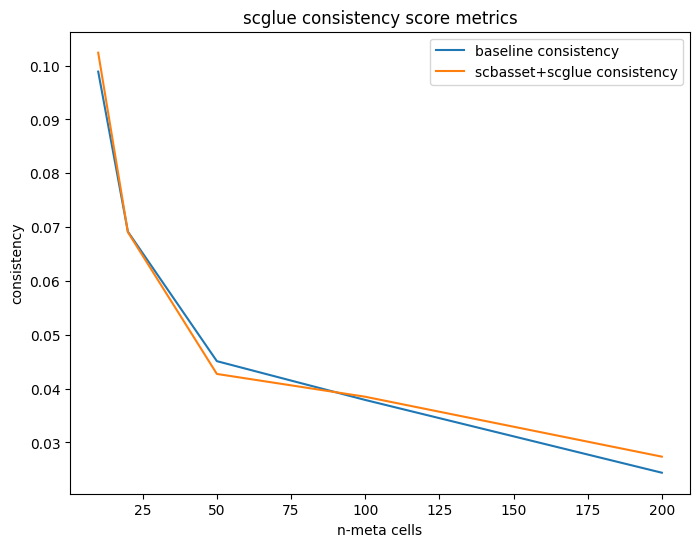

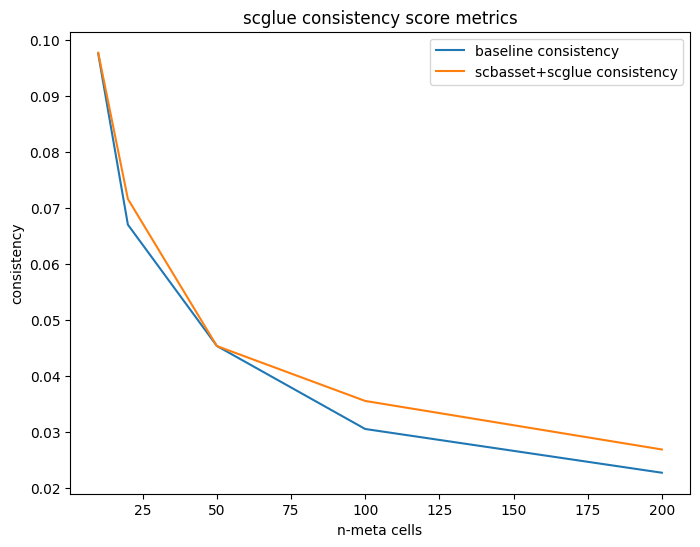

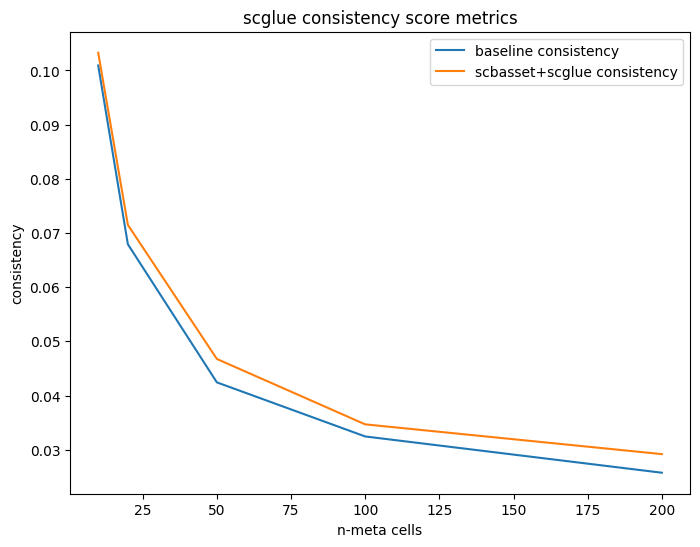

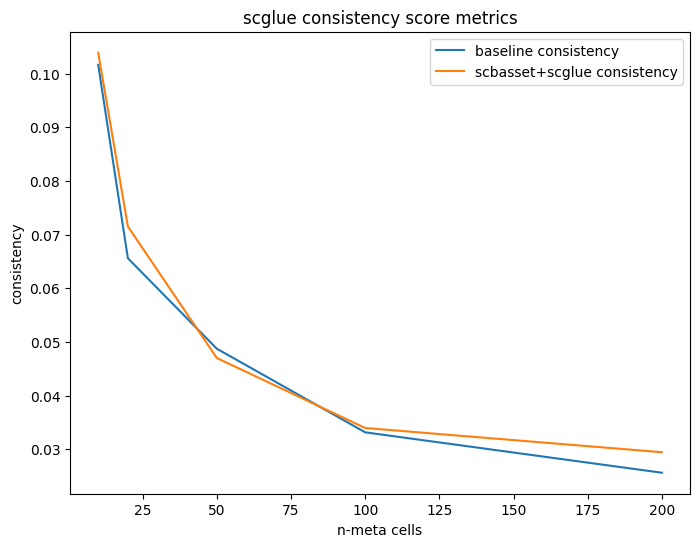

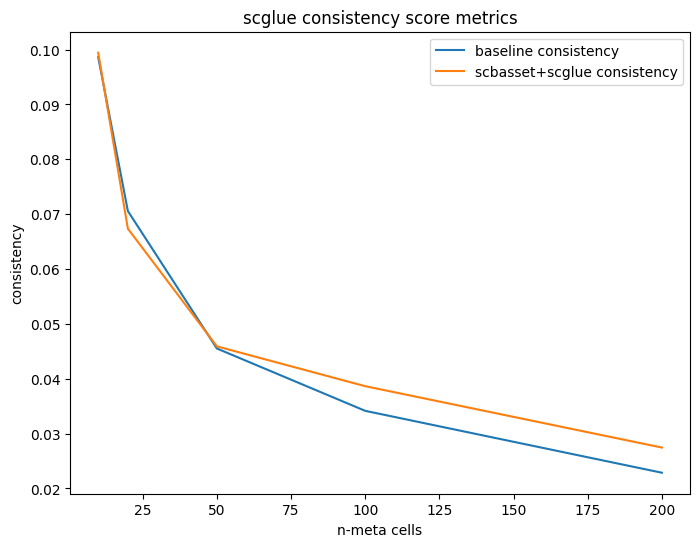

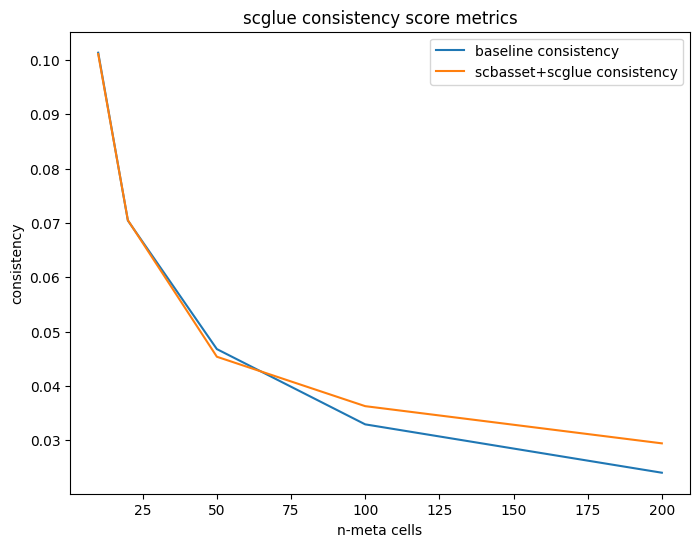

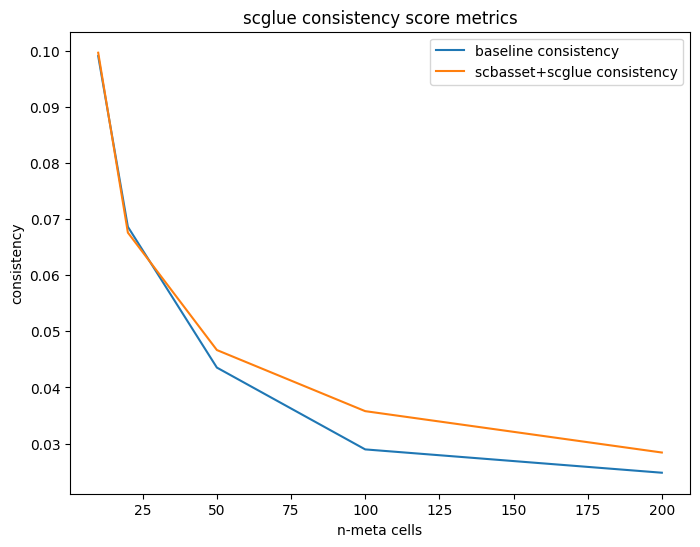

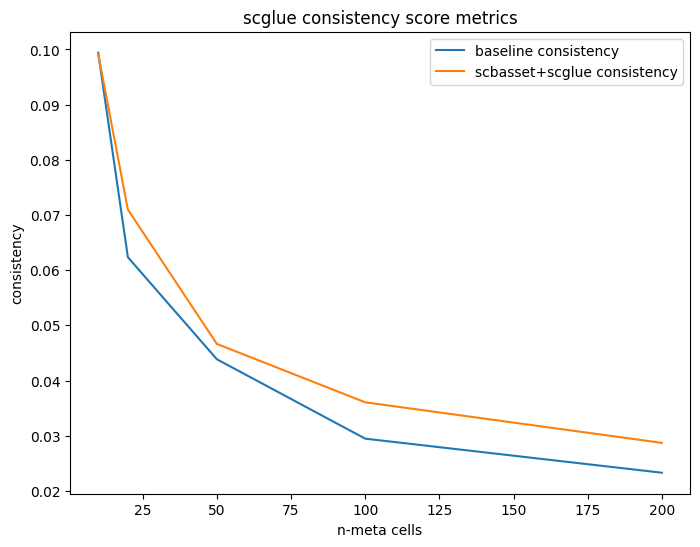

In [14]:

bio_result=[]
name_list=[]
for i in range(8):# to train glue embedding
    atac=atacl[i]
    guidance=guidancel[i]
    
    glue_scb,guidance_hvf_scb=train_glue(rna,atac,'proj',guidance)
    glue_scb.save(path+'glue/scb'+str(i)+'.dill')
    dx_scb = scglue.models.integration_consistency(glue_scb, {"rna": rna, "atac": atac}, guidance_hvf_scb)
    nx.write_graphml(guidance_hvf_scb,path+'hvfguidance/'+'hvfscb'+str(i))
    
    glue_lsi,guidance_hvf_lsi=train_glue(rna,atac,'X_lsi',guidance)
    glue_lsi.save(path+'glue/lsi'+str(i)+'.dill')
    nx.write_graphml(guidance_hvf_lsi,path+'hvfguidance/'+'hvflsi'+str(i))
    dx_lsi = scglue.models.integration_consistency(glue_lsi, {"rna": rna, "atac": atac}, guidance_hvf_lsi)
    plot_dx_together(dx_lsi,dx_scb,'dx600ep'+str(i)+'.png')
    


In [7]:
#scib check

df_list=[]
name_list=[]
for i in range(8):
    atac=atacl[i]
    glue_scb=scglue.models.load_model(path+'glue/scb'+str(i)+'.dill')
    glue_lsi=scglue.models.load_model(path+'glue/lsi'+str(i)+'.dill')
    atac.obsm['X_glue']=glue_lsi.encode_data('atac',atac)
    df1=run_scib2(atac,'X_glue')
    atac.obsm['X_glue']=glue_scb.encode_data('atac',atac)
    df2=run_scib2(atac,'X_glue')
    df_list.append(df1)
    df_list.append(df2)
    name_list.append('d'+str(i)+'lsi')
    name_list.append('d'+str(i)+'scbasset')


resolution: 0.1, nmi: 0.20846775507809534
resolution: 0.2, nmi: 0.4133558465301415
resolution: 0.3, nmi: 0.4825372308827788
resolution: 0.4, nmi: 0.49529827564822787
resolution: 0.5, nmi: 0.5006168112263283
resolution: 0.6, nmi: 0.5012382453223033
resolution: 0.7, nmi: 0.5030894041635398
resolution: 0.8, nmi: 0.5151706991073233
resolution: 0.9, nmi: 0.5196430934805802
resolution: 1.0, nmi: 0.5170699030821365
resolution: 1.1, nmi: 0.4840093466819549
resolution: 1.2, nmi: 0.47794098965764537
resolution: 1.3, nmi: 0.48408177156101523
resolution: 1.4, nmi: 0.47939059812513307
resolution: 1.5, nmi: 0.47241889052560637
resolution: 1.6, nmi: 0.47086028622208514
resolution: 1.7, nmi: 0.45555036143179883
resolution: 1.8, nmi: 0.4451993947017257
resolution: 1.9, nmi: 0.4517250737552092
resolution: 2.0, nmi: 0.4433169904606228
optimised clustering against cell_type
optimal cluster resolution: 0.9
optimal score: 0.5196430934805802
resolution: 0.1, nmi: 0.20846775507809534
resolution: 0.2, nmi: 0.4

In [8]:

bio_df,bio=metric_res(df_list,name_list)
# bio_df['bio']=bio_df['bio'].round(2)
bio_df

,ari,nmi,isolated_labels_aws,isolated_labels_f1,silhouette,clisi,bio
d0lsi,0.508992,0.519643,0.495006,0.389231,0.503848,0.934718,0.558573
d0scbasset,0.494357,0.506489,0.492277,0.376441,0.504690,0.936951,0.551867
d1lsi,0.497484,0.510671,0.489629,0.398680,0.505613,0.923436,0.554252
d1scbasset,0.478119,0.479900,0.485255,0.370285,0.507775,0.927841,0.541529
d2lsi,0.466135,0.512497,0.490506,0.394963,0.506166,0.931708,0.550329
d2scbasset,0.459939,0.491656,0.489620,0.377819,0.504823,0.932758,0.542769
d3lsi,0.468682,0.516000,0.490721,0.390610,0.505368,0.932632,0.550669
d3scbasset,0.477159,0.513771,0.488654,0.386854,0.508544,0.927582,0.550427
d4lsi,0.478950,0.510671,0.490892,0.396530,0.502756,0.922696,0.550416
d4scbasset,0.459138,0.488449,0.488906,0.370330,0.508885,0.927136,0.540474


In [9]:
bio

,ari,nmi,isolated_labels_aws,isolated_labels_f1,silhouette,clisi,bio
d0lsi,0.508992,0.519643,0.495006,0.389231,0.503848,0.934718,0.558573
d0scbasset,0.494357,0.506489,0.492277,0.376441,0.504690,0.936951,0.551867
d1lsi,0.497484,0.510671,0.489629,0.398680,0.505613,0.923436,0.554252
d1scbasset,0.478119,0.479900,0.485255,0.370285,0.507775,0.927841,0.541529
d2lsi,0.466135,0.512497,0.490506,0.394963,0.506166,0.931708,0.550329
d2scbasset,0.459939,0.491656,0.489620,0.377819,0.504823,0.932758,0.542769
d3lsi,0.468682,0.516000,0.490721,0.390610,0.505368,0.932632,0.550669
d3scbasset,0.477159,0.513771,0.488654,0.386854,0.508544,0.927582,0.550427
d4lsi,0.478950,0.510671,0.490892,0.396530,0.502756,0.922696,0.550416
d4scbasset,0.459138,0.488449,0.488906,0.370330,0.508885,0.927136,0.540474


In [10]:
import os 
os.makedirs(path+'Results',exist_ok=True)

In [11]:
bio_df.to_csv(path+'Results/scb600bio.csv')

<Figure size 768x576 with 0 Axes>

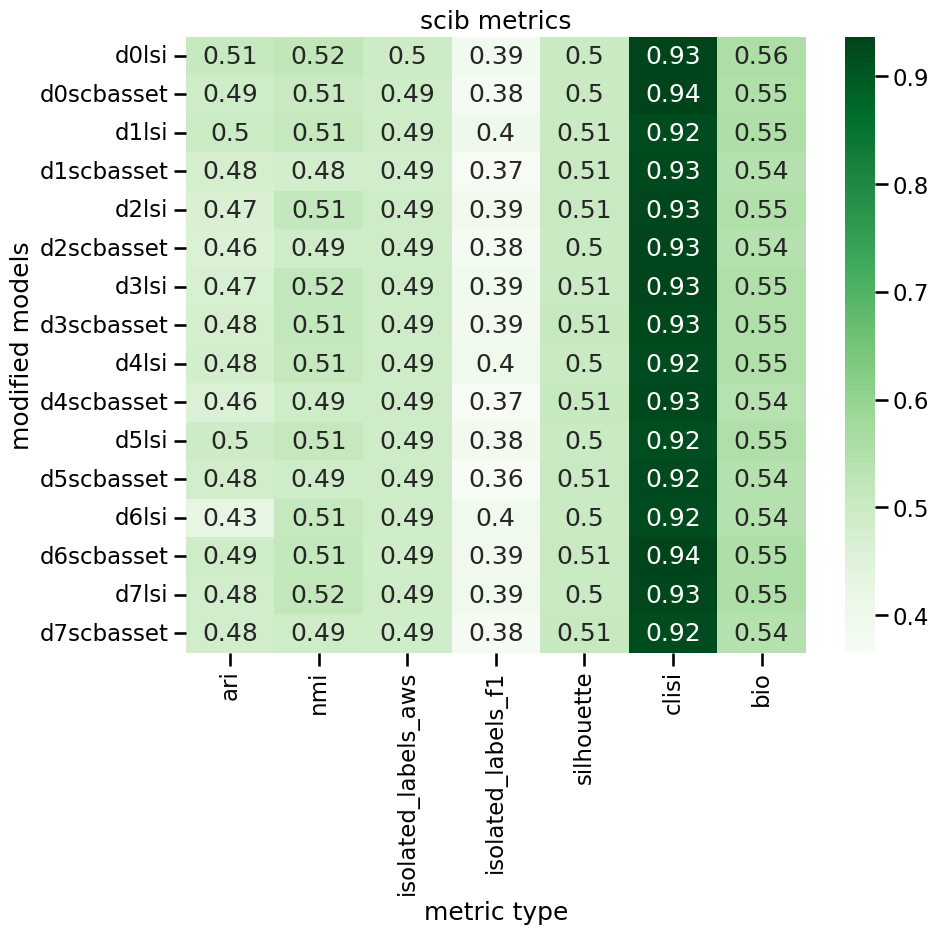

In [21]:
plt.figure(dpi=120)
f,ax=plt.subplots(figsize=(10,8))

sns.heatmap(data=bio_df,
           cmap=plt.get_cmap('Greens'),
           annot=True,
            #not_kws={'size':1},
            
           )

plt.title('scib metrics')
plt.xlabel('metric type')
plt.ylabel('modified models')
plt.savefig(path+'Results/scib_heatmap_600epochs.png',bbox_inches='tight')

In [22]:
data=bio_df['bio']
data=pd.DataFrame({'bio':data})
data_lsi = data.iloc[[0,2,4,6,8,10,12,14],:]
data_scb = data.iloc[[1,3,5,7,9,11,13,15],:]
from scipy import stats 
t_stat,pval=stats.ttest_ind(data_lsi['bio'],data_scb['bio'])
t_stat,pval #accept H0: two sample have similar distribution

(2.2732894057693787, 0.03928776587116591)

In [23]:
res_lsi=stats.normaltest(data_lsi)
print(res_lsi.pvalue)
res_scb=stats.normaltest(data_scb)
print(res_scb.pvalue)

[0.29621311]
[0.26381879]


/home/ubuntu0/miniconda3/envs/glue2_scib/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
